# Phys. Rev. Lett. **103**, 213603 - Plots

## Imports

In [1]:
# dependencies
import numpy as np
import scipy.constants as sc

# qom v0.7.0 modules
from qom.systems import SOSMSystem
from qom.ui import init_log
from qom.ui.plotters import MPLPlotter

# initialize log
init_log()

MainProcess              INFO    2021-05-16 10:23:37.482: (qom.ui.log) ------------------------------Logger Initialized-----------------


## The System Class

In [2]:
class System(SOSMSystem):
    """Class to simulate the gently modulated QOM system in PhysRevLett.103.213603.

    Parameters
    ----------
    params : dict
        Parameters for the system.
    """

    def __init__(self, params):
        """Class constructor for System."""
        
        # initialize super class
        super().__init__(params)

        # set attributes
        self.code = 'system'
        self.name = 'Gently Modulated QOM System'
        # default parameters
        self.params = {
            'F': params.get('F', 1.4e4),
            'lambda_l': params.get('lambda_l', 1064e-9),
            'L': params.get('L', 25e-3),
            'm': params.get('m', 150e-9),
            'omega_m': params.get('omega_m', 2e6 * np.pi),
            'P_0': params.get('P_0', 10e-3),
            'P_1': params.get('P_1', 2e-3),
            'Q': params.get('Q', 1e6),
            'T': params.get('T', 0.1)
        }
        # matrices
        self.A = None
        self.D = None

    def get_A(self, modes):
        """Function to obtain the drift matrix.

        Parameters
        ----------
        modes : list
            Values of the optical and mechancial modes.
        
        Returns
        -------
        A : list
            Drift matrix.
        """

        # extract frequently used variables
        alpha   = modes[0]
        beta    = modes[1]

        # get frequencies 
        Delta_0, G_0, omega_m, omega_l, Omega = self.get_frequencies()
        # get decays
        kappa, gamma_m = self.get_decays()

        # time frame
        tau = 2 * np.pi / Omega

        # effective values
        Delta = Delta_0 - np.sqrt(2) * G_0 * np.real(beta)
        G = np.sqrt(2) * G_0 * alpha

        # initialize drift matrix
        if self.A is None or np.shape(self.A) != (4, 4):
            self.A = np.zeros([4, 4], dtype=np.float_)
        # optical position quadrature
        self.A[0][0] = - kappa 
        self.A[0][1] = Delta 
        self.A[0][2] = - np.imag(G) 
        # optical momentum quadrature
        self.A[1][0] = - Delta
        self.A[1][1] = - kappa
        self.A[1][2] = np.real(G)
        # mechanical position quadrature
        self.A[2][3] = omega_m
        # mechanical momentum quadrature
        self.A[3][0] = np.real(G)
        self.A[3][1] = np.imag(G)
        self.A[3][2] = - omega_m
        self.A[3][3] = - gamma_m

        return self.A * tau

    def get_D(self):
        """Function to obtain the noise correlation matrix.
        
        Returns
        -------
        D : list
            Noise correlation matrix.
        """

        # extract frequently used variables
        T       = self.params['T']

        # get frequencies 
        Delta_0, G_0, omega_m, omega_l, Omega = self.get_frequencies()
        # get decays
        kappa, gamma_m = self.get_decays()
        # thermal phonon number
        if T != 0.0 or T != 0:
            n_th = 1 / (np.exp(sc.hbar * omega_m / (sc.k * T)) - 1)
        else:
            n_th = 0

        # time frame
        tau = 2 * np.pi / Omega

        # noise correlation matrix
        if self.D is None or np.shape(self.D) != (4, 4):
            self.D = np.zeros([4, 4], dtype=np.float_)
        # optical mode correlation relations
        self.D[0][0] = kappa
        self.D[1][1] = kappa
        self.D[3][3] = gamma_m * (2 * n_th + 1) 

        return self.D * tau

    def get_decays(self):
        """Function to obtain the optical and mechanical decay rates.
        
        Returns
        -------
        kappa : float
            Optical decay rate.
        gamma_m : float
            Mechanical decay rate.
        """
        
        # extract frequently used variables
        F       = self.params['F']
        L       = self.params['L']
        omega_m = self.params['omega_m']
        Q       = self.params['Q']

        # optical decay rate
        kappa = np.pi * sc.c / (2 * F * L)
        # mechanical decay rates
        gamma_m = omega_m / Q

        return kappa, gamma_m

    def get_frequencies(self):
        """Function to obtain the various frequencies.
        
        Returns
        -------
        Delta_0 : float
            Laser detuning.
        G_0 : float
            Interaction strength.
        omega_m : float
            Mechanical frequency.
        omega_l : float
            Laser frequency.
        Omega : float
            Modulation frequency.
        """
        
        # extract frequently used variables
        L       = self.params['L']
        lambda_l= self.params['lambda_l']
        m       = self.params['m']
        omega_m = self.params['omega_m']

        # update variables
        Delta_0 = omega_m
        omega_l = 2 * np.pi * sc.c / lambda_l
        omega_c = Delta_0 + omega_l
        G_0 = np.sqrt(sc.hbar / (m * omega_m)) * omega_c / L
        Omega = 2 * omega_m

        return Delta_0, G_0, omega_m, omega_l, Omega

    def get_rates_modes(self, modes, t):
        """Function to obtain the rates of the optical and mechanical modes.

        Parameters
        ----------
        modes : list
            Values of the modes.
        t : float
            Time at which the rates are calculated.
        
        Returns
        -------
        mode_rates : list
            Rates for each mode.
        """

        # extract frequently used variables
        P_0     = self.params['P_0']
        P_1     = self.params['P_1']
        alpha   = modes[0]
        beta    = modes[1]

        # get frequencies
        Delta_0, G_0, omega_m, omega_l, Omega = self.get_frequencies()
        # get decays
        kappa, gamma_m = self.get_decays()
        # laser amplitudes
        E_0 = np.sqrt(2 * kappa * P_0 / (sc.hbar * omega_l)) 
        E_1 = np.sqrt(2 * kappa * P_1 / (sc.hbar * omega_l)) 
        # time frame
        tau = 2 * np.pi / Omega

        # effective values
        Delta = Delta_0 - np.sqrt(2) * G_0 * np.real(beta)
        G = np.sqrt(2) * G_0 * alpha

        # calculate rates
        dalpha_dt = (- (kappa + 1j * Delta) * alpha + E_0 + E_1 * (np.exp(- 1j * Omega * t * tau) + np.exp(1j * Omega * t * tau)))
        dbeta_dt = (1j * G * np.conjugate(alpha) / 2 - (gamma_m + 1j * omega_m) * beta)

        # arrange rates
        mode_rates = [dalpha_dt * tau, dbeta_dt * tau]

        return mode_rates

    def ivc_func(self):
        """Function to obtain the initial values and constants required for the IVP.
        
        Returns
        -------
        iv : list
            Initial values of variables.

        c : list
            Constant parameters.
        """

        # extract frequently used variables
        omega_m = self.params['omega_m']
        T       = self.params['T']

        # thermal phonon number
        if T != 0.0 or T != 0:
            n_th = 1 / (np.exp(sc.hbar * omega_m / (sc.k * T)) - 1)
        else:
            n_th = 0
 
        # initial mode values as 1D list
        u_0 = np.zeros(2, dtype=np.complex_).tolist()

        # initial quadrature correlations
        V_0 = np.zeros([4, 4], dtype=np.float_)
        V_0[0][0] = 1/2 
        V_0[1][1] = 1/2
        V_0[2][2] = (n_th + 1/2)
        V_0[3][3] = (n_th + 1/2)

        # convert to 1D list and concatenate all variables
        iv = u_0 + [np.complex(element) for element in V_0.flatten()]

        return iv, None

    def ode_func(self, t, v):
        """Function for the rate equations of the modes and quadrature correlations.
        
        The variables are complex-valued, hence the model requires a complex-valued integrator.
        
        Parameters
        ----------
        t : *float*
            Time at which the rate is calculated.

        v : list
            Complex-valued variables defining the system. 
            First 2 elements contain the optical and mechanical modes.
            Next (4 * 4) elements contain the correlations.

        Returns
        -------
        rates : list
            Rates of the complex-valued variables defining the system. 
            First 2 elements contain the optical and mechanical modes.
            Next (4 * 4) elements contain the correlations.
        """

        # extract the modes and correlations
        modes   = v[0:2]
        corrs   = np.real(v[2:]).reshape([4, 4])

        # mode rates
        mode_rates  = self.get_rates_modes(modes, t)

        # drift matrix
        A = self.get_A(modes)
        # noise matrix
        D = self.get_D()

        # quadrature correlation rate equation
        dcorrs_dt = A.dot(corrs) + corrs.dot(np.transpose(A)) + D

        # mirror matrix
        for i in range(len(dcorrs_dt)):
            for j in range(0, i):
                dcorrs_dt[i, j] = dcorrs_dt[j, i]

        # convert to 1D list and concatenate all rates
        rates = mode_rates + [np.complex(element) for element in dcorrs_dt.flatten()]

        return rates

## Scripts

### Figure 2b

MainProcess              INFO    2021-05-16 10:23:41.389: (qom.solvers.HLESolver) -------------------Results Obtained-------------------
MainProcess              INFO    2021-05-16 10:23:41.429: (qom.systems.BaseSystem) ------------------Obtaining Measures-----------------
MainProcess              INFO    2021-05-16 10:23:41.577: (qom.systems.BaseSystem) ------------------Measures Obtained------------------
MainProcess              INFO    2021-05-16 10:23:45.788: (qom.solvers.HLESolver) -------------------Results Obtained-------------------
MainProcess              INFO    2021-05-16 10:23:45.828: (qom.systems.BaseSystem) ------------------Obtaining Measures-----------------
MainProcess              INFO    2021-05-16 10:23:45.971: (qom.systems.BaseSystem) ------------------Measures Obtained------------------


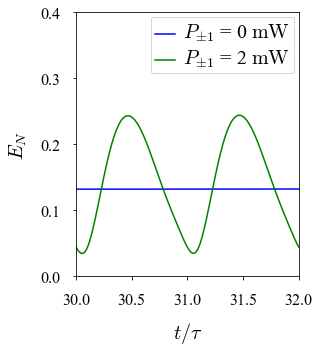

In [3]:
# all parameters
params = {
    'solver': {
        'show_progress': True,
        'cache': False,
        'method': 'ode',
        'measure_type': 'qcm',
        'qcm_type': 'entan',
        'idx_mode_i': 0,
        'idx_mode_j': 1,
        'range_min': 3000,
        'range_max': 3201,
        't_min': 0,
        't_max': 50,
        't_dim': 5001
    },
    'system': {
        'F': 1.4e4,
        'lambda_l': 1064e-9, 
        'L': 25e-3, 
        'm': 150e-12,
        'omega_m': 6283195.31,
        'P_0': 10e-3,
        'P_1': 2e-3,
        'Q': 1e6,
        'T': 0.1
    },
    'plotter': {
        'type': 'lines',
        'show_legend': True,
        'x_label': '$t / \\tau$',
        'y_name': '$P_{\\pm 1}$',
        'y_unit': '$\\mathrm{mW}$',
        'y_colors': ['b', 'g'],
        'v_label': '$E_{N}$',
        'v_bound': 'both',
        'v_ticks': [0.0, 0.1, 0.2, 0.3, 0.4]
    }
}

# initialize system
system = System(params['system'])

# without modulation
system.params['P_1'] = 0.0
M_0 = system.get_measure_dynamics(params['solver'], system.ode_func, system.ivc_func)
# with modulation
system.params['P_1'] = 2e-3
M_1 = system.get_measure_dynamics(params['solver'], system.ode_func, system.ivc_func)

# plotter
t_min = params['solver']['range_min']
t_max = params['solver']['range_max'] - 1
t_ss = (params['solver']['t_dim'] - 1) / params['solver']['t_max']
T = np.linspace(t_min / t_ss, t_max / t_ss, t_max - t_min + 1).tolist()
axes = {
    'X': T,
    'Y': {
        'var': 'P_1',
        'val': [0, 2]
    }
}
plotter = MPLPlotter(axes, params['plotter'])
_xs = [T, T]
_ys = [M_0, M_1]
plotter.update(xs=_xs, vs=_ys)
plotter.show(True)